# Time-Frequency Analysis 2.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyxdf
import mne
import pandas as pd
import copy

from matplotlib.colors import TwoSlopeNorm
import seaborn as sns
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import helpers
from helpers import *
import importlib


%matplotlib inline


In [14]:
importlib.reload(helpers)
from helpers import *

In [2]:
%gui qt

### Local Constants

In [3]:
EVENTS_IDS = {
    'MI' : ['Left','Right','Third'],
    'PO' : [2,5,8]
}

### Local Functions

In [4]:
def get_evoked(EEG_dict):
    evoked_dict = dict()
    eeg_montage = mne.channels.read_custom_montage(MONTAGE)
    for condition in list(EEG_dict.keys()):
        epochs = EEG_dict[condition]['epochs']
        if epochs != None:
            event_type = [key for key in list(EVENTS_IDS.keys()) if key in condition][0];
            events = EVENTS_IDS[event_type]
            evoked = dict()
            for event in events:
                evoked_event = epochs[event].average()
                evoked_event.info.set_montage(eeg_montage)
                evoked[event] = evoked_event

            evoked_dict[condition] = evoked
    
    return evoked_dict

def get_ERDS(EEG_dict_epoched):
    
    freqs = np.arange(1, 40)  # frequencies from 2-35Hz
    vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
    baseline = (-2, 0)  # baseline interval (in s)
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

    kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                buffer_size=None, out_type='mask')  # for cluster test
    tmin, tmax = -2, 7

    conditions = list(EEG_dict_epoched.keys())

    subject_ID = conditions[0].split('-')[1].split('_')[0]
    
    if int(subject_ID[1:3]) < 11:
        grp = "Group_Realistic_Arm"
    else:
        grp = "Group_Realistic_Arm_Tactile"
            
    path = "Data/" + grp + "/" + subject_ID + "/" + "ERDS/"
    isExist = os.path.exists(path)

    if not isExist:
        os.makedirs(path)

    for condition in conditions:

        if EEG_dict_epoched[condition]['epochs'] != None:
            epochs_MI = EEG_dict_epoched[condition]['epochs'].copy().pick_channels(['C1', 'C2', 'C3', 'CZ', 'C4', 'C5', 'C6'])
            tfr = tfr_multitaper(epochs_MI , freqs=freqs, n_cycles=freqs, use_fft=True,
                            return_itc=False, average=False, decim=2)
            tfr.crop(-2, 7).apply_baseline(baseline, mode="percent")
            df = tfr.to_data_frame(time_format = None, long_format = True)
            freq_bounds = {'_': 0,
                    'delta': 3,
                    'theta': 7,
                    'alpha': 13,
                    'beta': 30,
                    'gamma' : 140}
            df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                            labels=list(freq_bounds)[1:])
            # Filter to retain only relevant frequency bands:
            freq_bands_of_interest = ['alpha', 'beta','theta','gamma']
            df = df[df.band.isin(freq_bands_of_interest)]
            df['band'] = df['band'].cat.remove_unused_categories()
            df['channel'] = df['channel'].cat.reorder_categories(('C1', 'C2', 'C3', 'C4', 'C5', 'C6'),
                                                            ordered=True)
            g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
            g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10)
            axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
            g.map(plt.axhline, y=0, **axline_kw)
            g.map(plt.axvline, x=0, **axline_kw)
            g.set(ylim=(-2, 6))
            g.set_axis_labels("Time (s)", "ERDS (%)")
            g.set_titles(col_template="{col_name}", row_template="{row_name}")
            g.add_legend(ncol=2, loc='lower center')
            g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)
            g.savefig(path+condition)
        
def misc():
    EEG_dict_corrected = {}
    ICA_dict = {}
    EEG_dict_2 = EEG_dict

    for condition in list(EEG_dict.keys()):
        ICA_dict[condition] = mne.preprocessing.read_ica(path+'/ICA_data/'+condition+'_ica')
        
    EEG_dict,EEG_dict_corrected = apply_ica(EEG_dict,ICA_dict)
        
    for condition in list(EEG_dict.keys()):
        signal = EEG_dict_corrected[condition]['signal']
        signal, ref_data = mne.set_eeg_reference(signal, ref_channels='average', copy=True)
        EEG_dict_corrected[condition]['signal'] = signal


    EEG_dict_epoched = get_epochs(EEG_dict_corrected,EVENTS_dict)
    #save_fif(EEG_dict_epoched)

def filter_dict(EEG_dict,filter):

    EGG_dict_filt = copy.deepcopy(EEG_dict)

    for condition in list(EEG_dict.keys()):
        signal = EEG_dict[condition]['signal'].copy().filter(filter[0],filter[1])
        EGG_dict_filt[condition]['signal'] = signal

    return EGG_dict_filt



def eeg_square(EEG_dict):
    new_dict = copy.deepcopy(EEG_dict)

    for condition in list(new_dict.keys()):
        signal = new_dict[condition]['signal'].copy()
        new_eeg = mne.io.RawArray(np.square(signal.get_data()),signal.info)
        new_dict[condition]['signal'] = new_eeg
    return new_dict

def pfurt_erds(EEG_dict_filtered,EVENTS_dict):
    bands = list(EEG_dict_filtered.keys())
    new_dict = copy.deepcopy(EEG_dict_filtered)
    for band in bands:
        current_eeg_dict = new_dict[band]
        conditions = list(current_eeg_dict.keys())
        MIPOST = [x for x in conditions if 'MIpost' in x][0]
        MIPRE = [x for x in conditions if 'MIpre' in x][0]


        current_eeg_dict = eeg_square(select_keys(current_eeg_dict,{MIPRE,MIPOST}))
        current_eeg_dict = get_epochs(current_eeg_dict,EVENTS_dict,False)
        new_dict[band] = current_eeg_dict
        
    return new_dict

def plot_ERDS(EEG_dict,EVENTS_dict):

    freqs = np.arange(1, 40)  # frequencies from 2-35Hz
    vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
    baseline = (-2, 0)  # baseline interval (in s)
    cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

    kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
                buffer_size=None, out_type='mask')  # for cluster test
    tmin, tmax = -2, 7

    conditions = list(EEG_dict.keys())
    MIPOST = [x for x in conditions if 'MIpost' in x][0]
    MIPRE = [x for x in conditions if 'MIpre' in x][0]
    working_EEG = get_epochs(select_keys(EEG_dict,{MIPOST,MIPRE}),EVENTS_dict,False)
    evoked_dict = get_evoked(working_EEG)

    epochs_MI = working_EEG[MIPRE]['epochs'].copy()
    epochs_MI.load_data()
    epochs_MI.pick_channels(['C3', 'CZ', 'C4'])

    tfr = tfr_multitaper(epochs_MI , freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
    tfr.crop(-2, 7).apply_baseline(baseline, mode="percent")
    df = tfr.to_data_frame(time_format = None, long_format = True)
    # Map to frequency bands:
    freq_bounds = {'_': 0,
                'delta': 3,
                'theta': 7,
                'alpha': 12,
                'beta': 34,
                'gamma' : 140}
    df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                        labels=list(freq_bounds)[1:])
    # Filter to retain only relevant frequency bands:
    freq_bands_of_interest = ['alpha', 'beta','theta','gamma']
    df = df[df.band.isin(freq_bands_of_interest)]
    df['band'] = df['band'].cat.remove_unused_categories()
    df['channel'] = df['channel'].cat.reorder_categories(('C3','CZ', 'C4'),
                                                     ordered=True)
    g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
    g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10,)
    axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
    g.map(plt.axhline, y=0, **axline_kw)
    g.map(plt.axvline, x=0, **axline_kw)
    g.set(ylim=(-2, 6))
    g.set_axis_labels("Time (s)", "ERDS (%)")
    g.set_titles(col_template="{col_name}", row_template="{row_name}")
    g.add_legend(ncol=2, loc='lower center')
    g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

    plt.show()

    del epochs_MI

In [5]:
filters = {
    "delta":[0.5,4],
    "theta":[4,8],
    "alpha":[8,12],
    "beta":[12,35],
    "gamma":[35,130]
}

### Get ERDS for all subjects

In [ ]:
subjects_idx = np.arange(1,11)
for idx in subjects_idx:
    EEG_dict,EEG_dict_epoched = get_subject(idx)
    get_ERDS(EEG_dict_epoched)

In [15]:
%%capture
EEG_dict,EEG_dict_corrected,EEG_filtered,EVENTS_dict = get_subject(5,filters)

KeyboardInterrupt: 

In [ ]:
%%capture
eeg_dict = pfurt_erds(EEG_filtered,EVENTS_dict)

In [19]:
EEG_filtered['alpha']

{'sub-S05_eegBaselineCO': {'signal': <RawArray | 64 x 242018 (121.0 s), ~118.2 MB, data loaded>,
  'epochs': None},
 'sub-S05_eegBaselineEO': {'signal': <RawArray | 64 x 246034 (123.0 s), ~120.2 MB, data loaded>,
  'epochs': None},
 'sub-S05_MIpost': {'signal': <RawArray | 64 x 1260027 (630.0 s), ~615.3 MB, data loaded>,
  'epochs': <Epochs |  60 events (good & bad), -2 - 7 sec, baseline -2 – 0 sec, ~64 kB, data not loaded,
   'Left': 20
   'Right': 20
   'Third': 20>},
 'sub-S05_MIpre': {'signal': <RawArray | 64 x 1219062 (609.5 s), ~595.3 MB, data loaded>,
  'epochs': <Epochs |  60 events (good & bad), -2 - 7 sec, baseline -2 – 0 sec, ~64 kB, data not loaded,
   'Left': 20
   'Right': 20
   'Third': 20>},
 'sub-S05_PO': {'signal': <RawArray | 64 x 2027056 (1013.5 s), ~989.8 MB, data loaded>,
  'epochs': <Epochs |  60 events (good & bad), -2 - 7 sec, baseline -2 – 0 sec, ~64 kB, data not loaded,
   '2': 20
   '5': 20
   '8': 20>}}

In [ ]:
conditions = list(EEG_dict_corrected.keys())
MIPOST = [x for x in conditions if 'MIpost' in x][0]
MIPRE = [x for x in conditions if 'MIpre' in x][0]
working_EEG = get_epochs(select_keys(EEG_dict_corrected,{MIPOST,MIPRE}),EVENT_dict,False)

### Analysis

In [ ]:
evoked_dict = get_evoked(working_EEG)

#### Plotting of evoked responses

In [87]:
freqs = np.arange(1, 40)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-2, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test
tmin, tmax = -2, 7

epochs_MI = working_EEG[MIPRE]['epochs'].copy()

#### MI study

In [88]:
epochs_MI.load_data()
epochs_MI.pick_channels(['C3', 'CZ', 'C4'])

Using data from preloaded Raw for 60 events and 18001 original time points ...
0 bad epochs dropped


Number of events,60
Events,Left: 20Right: 20Third: 20
Time range,-2.000 – 7.000 sec
Baseline,-2.000 – 0.000 sec


In [89]:
tfr = tfr_multitaper(epochs_MI , freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.9s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.7s finished


In [91]:
tfr.crop(-2, 7).apply_baseline(baseline, mode="percent")

Applying baseline correction (mode: percent)


c:\Users\haiou\python-env\.venv\env_TNE\lib\site-packages\mne\baseline.py:108: RuntimeWarning: divide by zero encountered in divide
  d /= m


<EpochsTFR | time : [-2.000000, 7.000000], freq : [1.000000, 39.000000], epochs : 60, channels : 3, ~482.1 MB>

In [92]:
df = tfr.to_data_frame(time_format = None, long_format = True)

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


In [69]:
df_saved = df.copy()

In [93]:
# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 12,
               'beta': 34,
               'gamma' : 140}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

In [94]:
# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['alpha', 'beta','theta','gamma']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

In [78]:
df.channel

81009       C3
81010       CZ
81011       C4
81012       C3
81013       CZ
            ..
63187015    CZ
63187016    C4
63187017    C3
63187018    CZ
63187019    C4
Name: channel, Length: 58326480, dtype: category
Categories (3, object): ['C3', 'C4', 'CZ']

In [95]:
df['channel'] = df['channel'].cat.reorder_categories(('C3','CZ', 'C4'),
                                                     ordered=True)

In [96]:
g = sns.FacetGrid(df, row='band', col='channel', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'condition', n_boot=10,)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)
g.set(ylim=(-2, 6))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

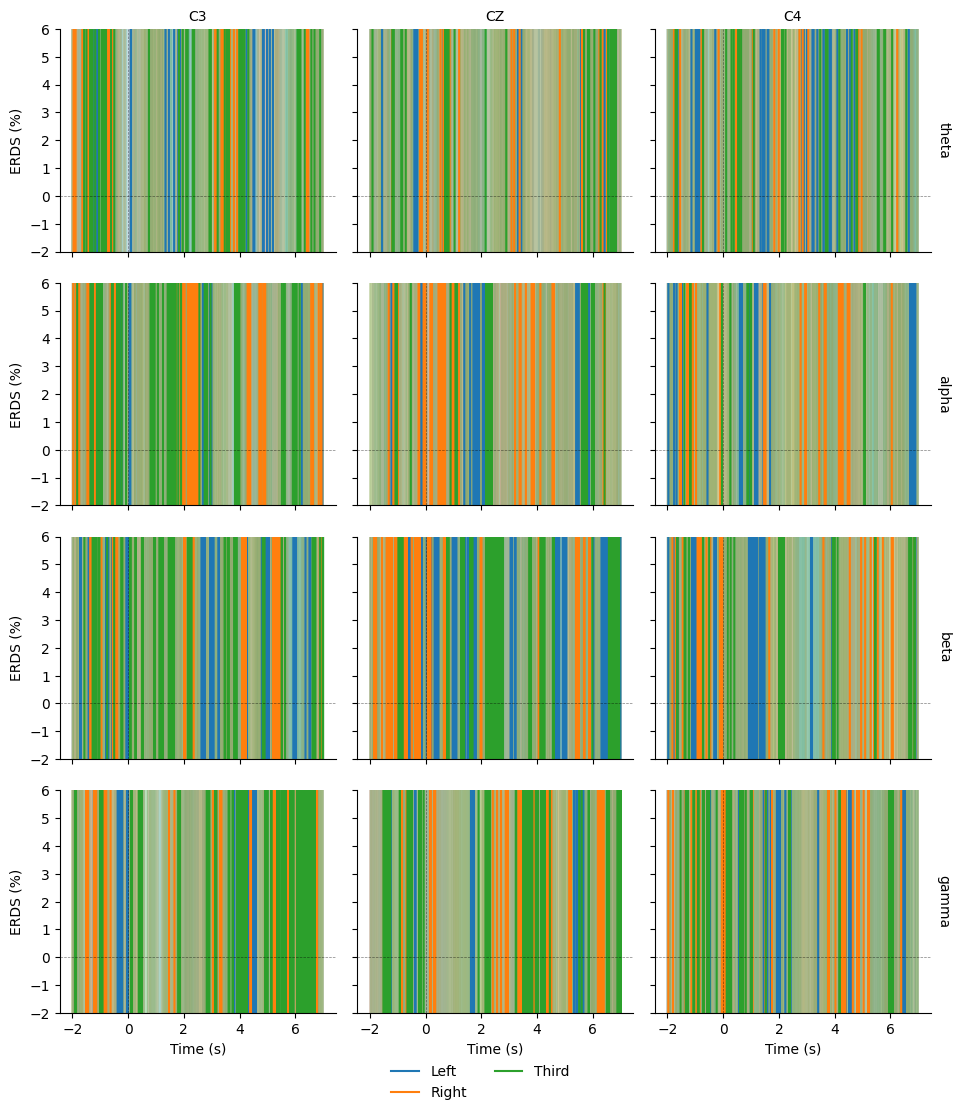

In [97]:
plt.show()

#### Plot topomap

In [ ]:
epochs = working_EEG['sub-S04_MIpost']['epochs']
freqs = np.arange(1.5, 40)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(1, 4, figsize=(12, 4),
                             gridspec_kw={"width_ratios": [10, 10, 10, 1]})
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot([ch], cmap="RdBu", cnorm=cnorm, axes=ax,
                              colorbar=False, show=False, mask=mask,
                              mask_style="mask")

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

In [59]:
df = tfr.to_data_frame(time_format = None, long_format = True)
df.head()

In [ ]:
# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 30,}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

In [ ]:
# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

In [18]:
epochs = EEG_dict_epoched['sub-S05_MIpost']['epochs']
epochs_right = epochs['Right']
evoked_right = epochs_right.average()
eeg_montage = mne.channels.read_custom_montage(MONTAGE)
evoked_right.info.set_montage(eeg_montage)

C:\Users\haiou\AppData\Local\Temp\ipykernel_20428\3540735997.py:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_right.info.set_montage(eeg_montage)


<Info | 10 non-empty values
 bads: 3 items (M1, M2, EOG)
 ch_names: FP1, FPZ, FP2, F7, F3, FZ, F4, F8, FC5, FC1, FC2, FC6, M1, T7, ...
 chs: 64 EEG
 custom_ref_applied: True
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.1 Hz
 lowpass: 40.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 2000.0 Hz
>

In [19]:
events_type = ['Left','Right','Third']
evoked = dict()
for event in events_type:
    evoked_event = epochs[event].average()
    evoked_event.info.set_montage(eeg_montage)
    evoked[event] = evoked_event

C:\Users\haiou\AppData\Local\Temp\ipykernel_20428\2289521761.py:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)
C:\Users\haiou\AppData\Local\Temp\ipykernel_20428\2289521761.py:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)
C:\Users\haiou\AppData\Local\Temp\ipykernel_20428\2289521761.py:5: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)


In [20]:
print(evoked_right.info.ch_names)

['FP1', 'FPZ', 'FP2', 'F7', 'F3', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'M1', 'T7', 'C3', 'CZ', 'C4', 'T8', 'M2', 'CP5', 'CP1', 'CP2', 'CP6', 'P7', 'P3', 'PZ', 'P4', 'P8', 'POZ', 'O1', 'O2', 'EOG', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FCZ', 'FC4', 'C5', 'C1', 'C2', 'C6', 'CP3', 'CP4', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'OZ']


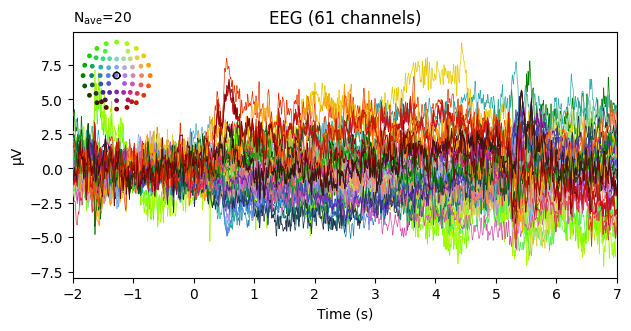

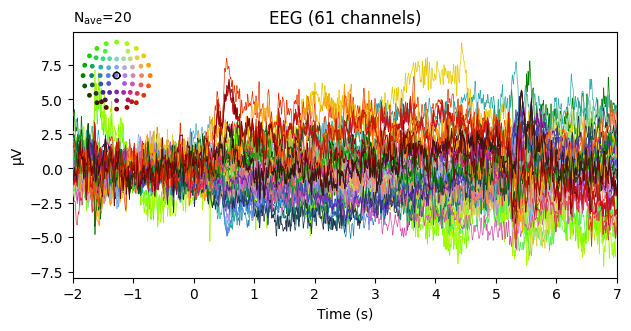

In [21]:
evoked['Third'].plot()

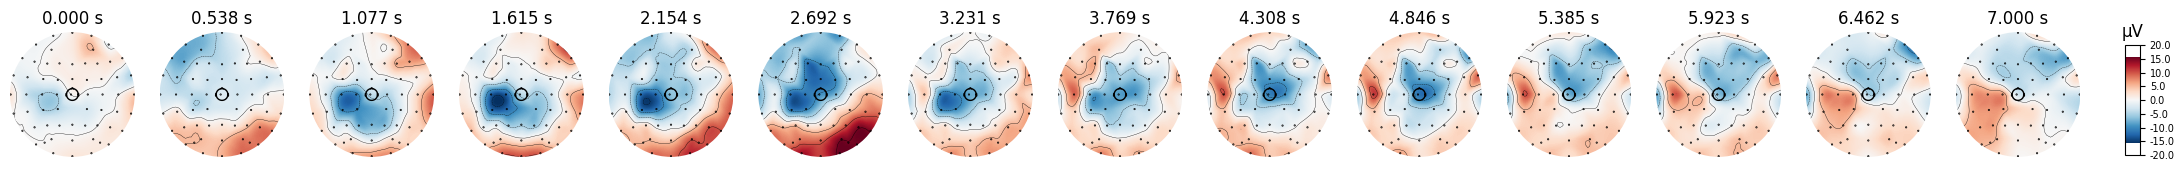

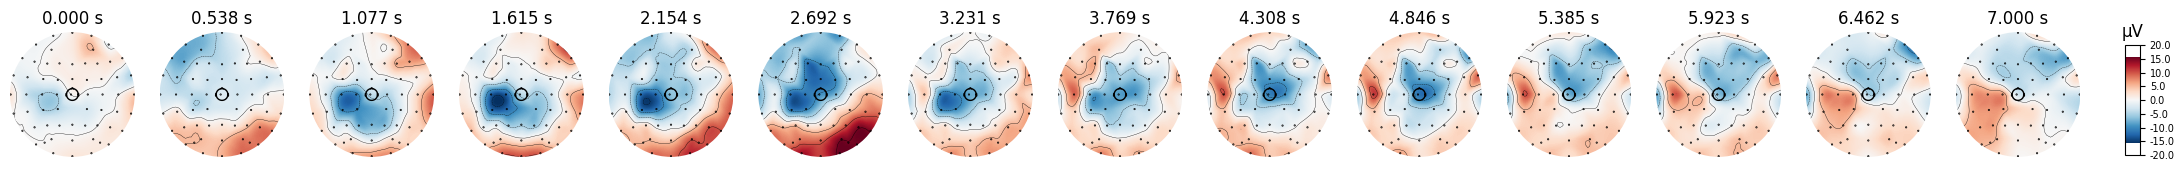

In [15]:
times = np.linspace(0, 7, 14)
evoked_dict['sub-S12_MIpost_ses-S001_task-Default_run-001_eeg']['Left'].plot_topomap(ch_type='eeg', times=times, colorbar=True)

No projector specified for this dataset. Please consider the method self.add_proj.


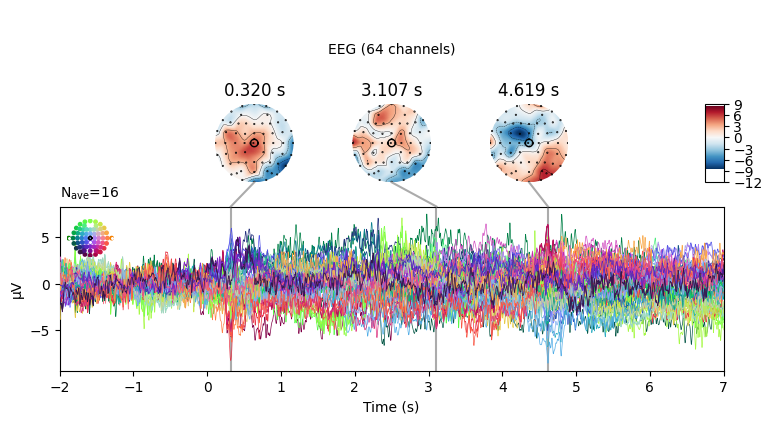

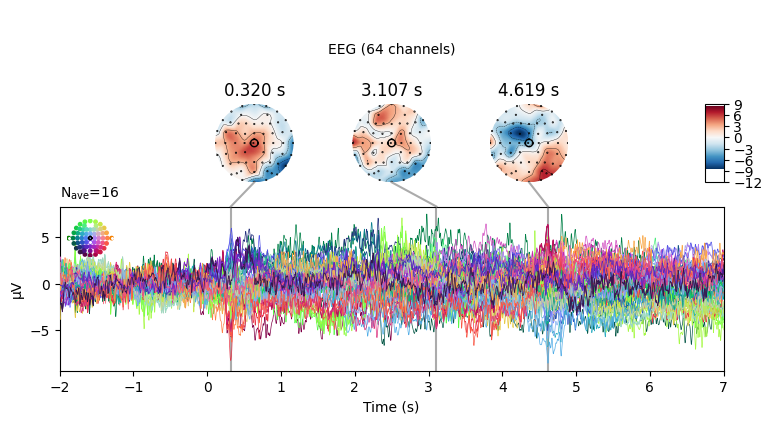

In [42]:
evoked_dict['sub-S05_MIpost']['Third'].plot_joint(exclude=[])

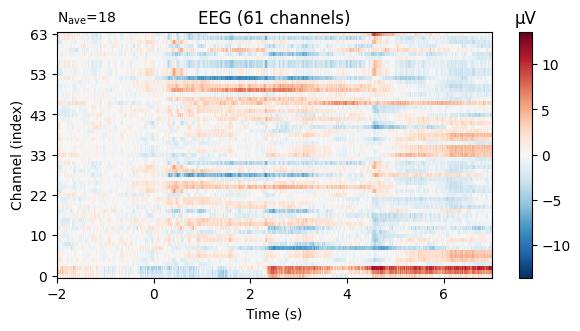

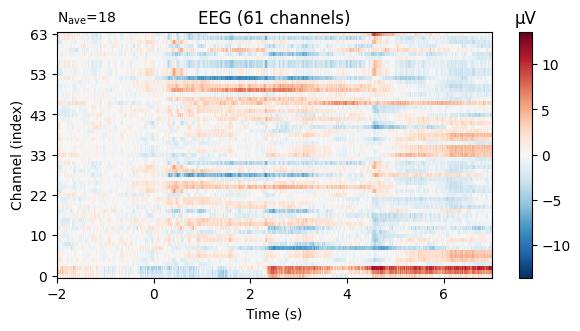

In [43]:
evoked_dict['sub-S05_MIpost']['Right'].plot_image()

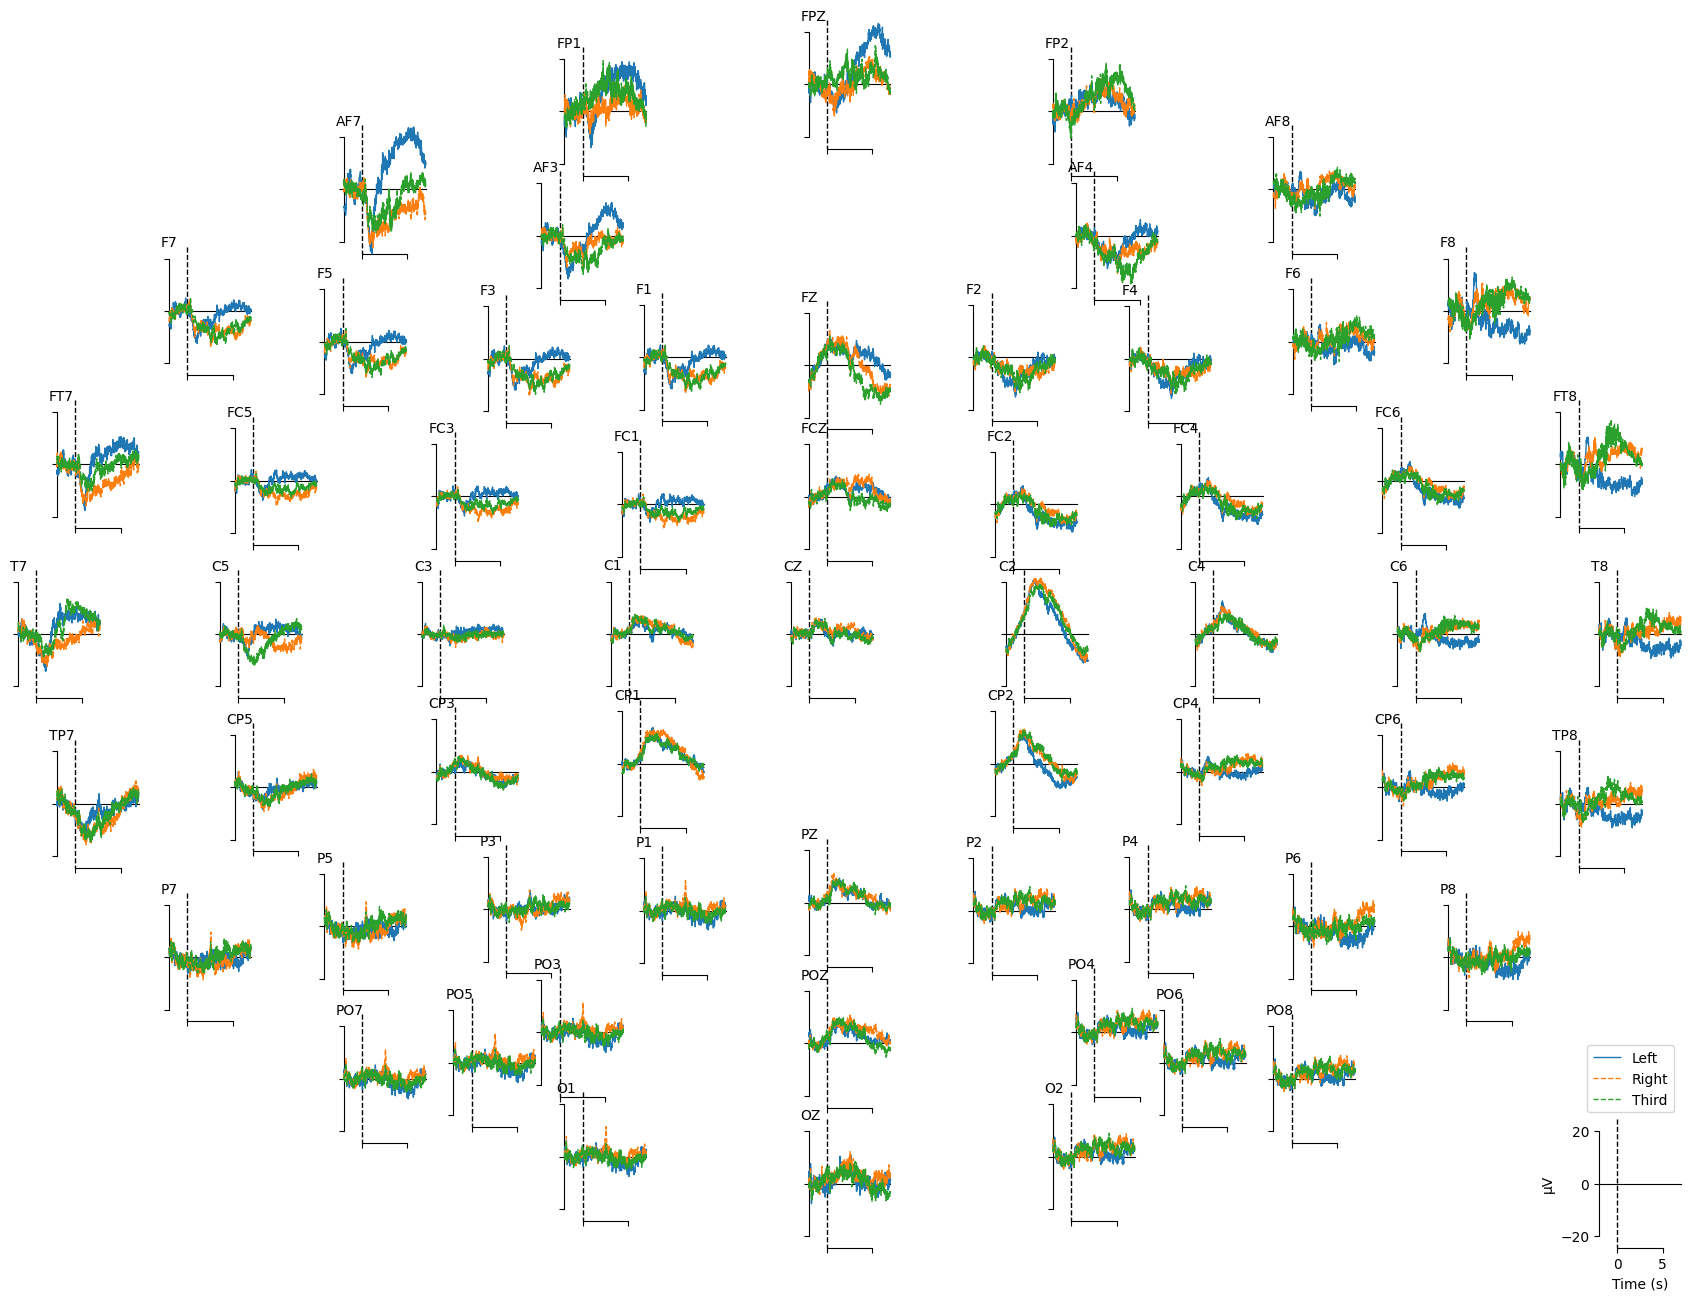

[<Figure size 1800x1400 with 62 Axes>]

In [13]:
mne.viz.plot_compare_evokeds(evoked_dict['sub-S04_MIpre'], picks='eeg', colors=dict(Left=0, Right=1,Third=3),
                             linestyles=dict(Left='solid', Right='dashed',Third='--'),
                             axes='topo', styles=dict(Left=dict(linewidth=1),
                                                      Right=dict(linewidth=1),
                                                      Third=dict(linewidth=1)))

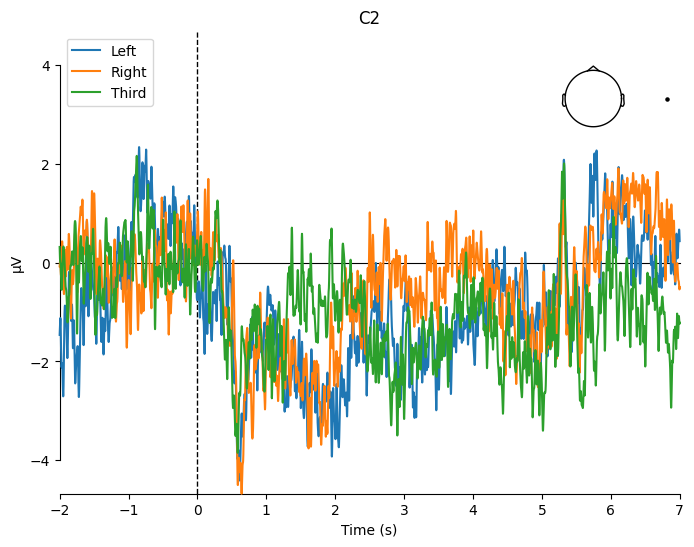

[<Figure size 800x600 with 2 Axes>]

In [32]:
mne.viz.plot_compare_evokeds(evoked,picks=['C2'])

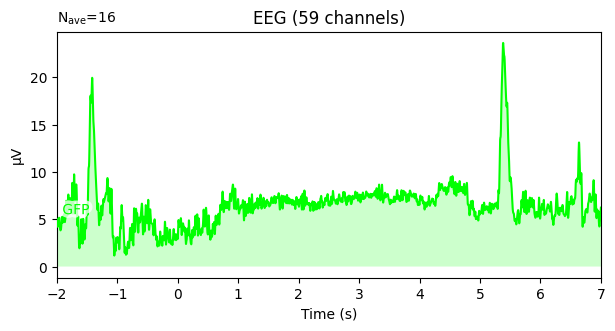

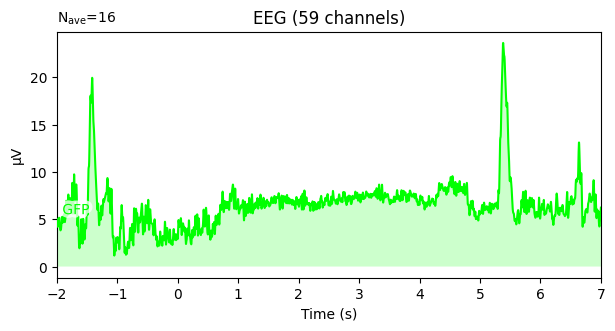

In [80]:
evoked['Third'].plot(gfp='only')

### Explore event-related dynamics for specific frequency bands

In [5]:
from mne.baseline import rescale
from mne.datasets import somato
from mne.stats import bootstrap_confidence_interval

In [6]:
# let's explore some frequency bands
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [ ]:
EEG_dict['sub-S04_MIpost']['signal'].plot(scalings=0.0003)

In [37]:
working_EEG = copy.deepcopy(EEG_dict_corrected)

In [38]:
%%capture
frequency_map = list()
condition = 'sub-S04_MIpost'
eeg_dict = select_keys(EEG_dict_corrected,{condition})
for band, fmin, fmax in iter_freqs:
    current_eeg = copy.deepcopy(eeg_dict)
    # bandpass filter
    current_eeg[condition]['signal'] = current_eeg[condition]['signal'].copy().filter(fmin, fmax, n_jobs=None,  # use more jobs to speed up.
                                                                                    l_trans_bandwidth=1,  # make sure filter params are the same
                                                                                    h_trans_bandwidth=1)  # in each band and skip "auto" option.

    # epoch
    current_eeg = get_epochs(current_eeg,EVENT_dict,False)
    # remove evoked response
    epochs = current_eeg[condition]['epochs'].copy()
    epochs = epochs['Right']
    epochs.load_data()
    epochs.subtract_evoked()

    # get analytic signal (envelope)
    epochs.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs.average()))


In [39]:
# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.colormaps['winter_r'](np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel('Time [ms]')

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')

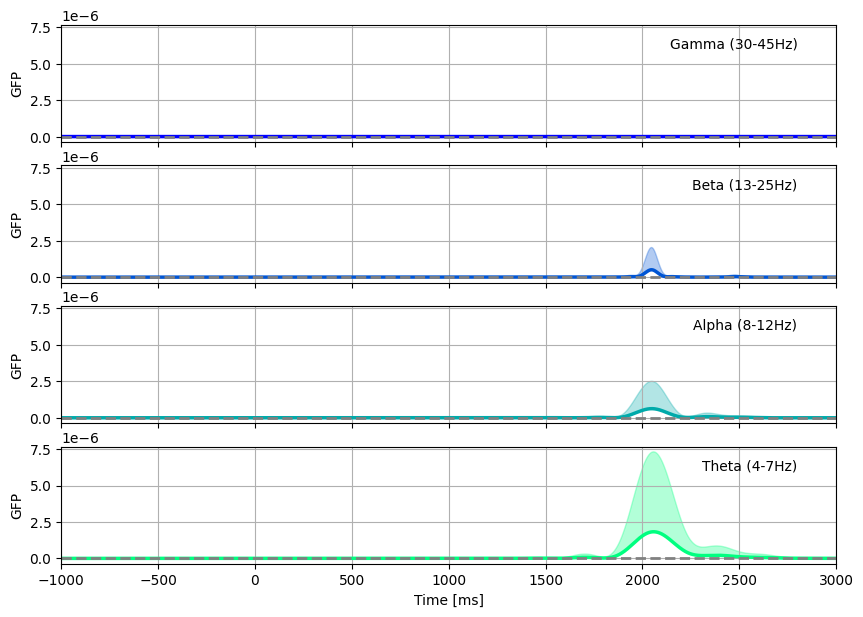

In [36]:
plt.show()

### Manual ERDS

In [7]:
signal = EEG_dict_corrected['sub-S04_MIpost']['signal'].copy()

In [21]:
new_eeg = mne.io.RawArray(np.square(signal.get_data()),signal.info)

Creating RawArray with float64 data, n_channels=64, n_times=1228009
    Range : 0 ... 1228008 =      0.000 ...   614.004 secs
Ready.


In [31]:
new_dict = copy.deepcopy(EEG_dict_corrected)
new_dict = select_keys(new_dict,{'sub-S04_MIpost'})

In [33]:
new_dict['sub-S04_MIpost']['signal'] = new_eeg
new_dict = get_epochs(new_dict,EVENT_dict,False)

Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 18001 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)


In [34]:
evoked_dict = get_evoked(new_dict)

    Rejecting  epoch based on EEG : ['F8', 'T7', 'FT7', 'FT8']
    Rejecting  epoch based on EEG : ['F8', 'FT8']
    Rejecting  epoch based on EEG : ['FP1', 'FPZ', 'FP2', 'F7', 'F3', 'F4', 'F8', 'FC2', 'FC6', 'T7', 'C4', 'T8', 'CP5', 'P7', 'P3', 'PZ', 'P4', 'P8', 'POZ', 'O1', 'O2', 'AF7', 'AF3', 'AF4', 'AF8', 'F5', 'F1', 'F2', 'F6', 'FC3', 'FC4', 'C5', 'C6', 'CP3', 'P5', 'P1', 'P2', 'P6', 'PO5', 'PO3', 'PO4', 'PO6', 'FT7', 'FT8', 'TP7', 'TP8', 'PO7', 'PO8', 'OZ']
    Rejecting  epoch based on EEG : ['FP1', 'F4', 'F8', 'P7', 'AF7', 'AF8', 'F2', 'F6', 'P5', 'FT7', 'FT8']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['F8', 'FT8']
    Rejecting  epoch based on EEG : ['FPZ', 'AF8']
    Rejecting  epoch based on EEG : ['FP1', 'AF7', 'AF3', 'AF8']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FT8']
    Rejecting  epoch based on EEG : ['T7', 'FT8', 'TP7']
    Rejecting  epoch based on EEG : ['FP1', 'FP2', 'FC5', 'FC1', 'T7'

C:\Users\haiou\AppData\Local\Temp\ipykernel_2684\1065642881.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)


    Rejecting  epoch based on EEG : ['FP1', 'AF7', 'AF8']
    Rejecting  epoch based on EEG : ['T7', 'AF7', 'TP7']
    Rejecting  epoch based on EEG : ['FT8', 'TP7']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1']
    Rejecting  epoch based on EEG : ['FP1', 'FP2', 'AF8']


C:\Users\haiou\AppData\Local\Temp\ipykernel_2684\1065642881.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)


    Rejecting  epoch based on EEG : ['FP2', 'T7', 'FT8', 'TP7']
    Rejecting  epoch based on EEG : ['AF8']
    Rejecting  epoch based on EEG : ['FP1', 'FPZ', 'FP2', 'FZ', 'F4', 'F8', 'FC5', 'FC1', 'FC2', 'FC6', 'T7', 'C3', 'CZ', 'C4', 'T8', 'CP5', 'P3', 'P8', 'AF7', 'AF3', 'AF4', 'AF8', 'F2', 'F6', 'FC3', 'FCZ', 'FC4', 'C2', 'C6', 'P6', 'FT8', 'TP8']
    Rejecting  epoch based on EEG : ['FP1', 'FPZ', 'AF7', 'AF8', 'C2']
    Rejecting  epoch based on EEG : ['FP1', 'FPZ', 'AF7', 'AF4', 'AF8']


C:\Users\haiou\AppData\Local\Temp\ipykernel_2684\1065642881.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)


In [39]:
baseline = (-2, 0)
evoked_right = evoked_dict['sub-S04_MIpost']['Right'].copy()
evoked_right.apply_baseline(baseline)

Applying baseline correction (mode: mean)


<Evoked | 'Right' (average, N=15), -2 – 7 sec, baseline -2 – 0 sec, 64 ch, ~8.9 MB>

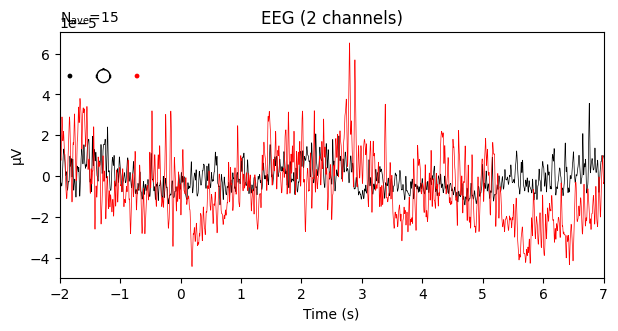

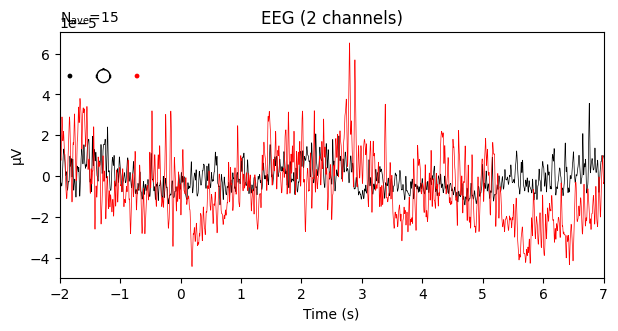

In [41]:
evoked_right.plot(picks=['C3','C4'])

In [18]:
print(signal.get_data())

[[ 5.38474322e-08  1.11024482e-06  2.16035992e-06 ...  4.36073779e-07
   2.40399696e-07  5.38474322e-08]
 [ 1.07586472e-07  1.29206504e-06  2.46752134e-06 ...  4.74267001e-07
   2.91086921e-07  1.07586472e-07]
 [ 1.53679789e-07  3.79924570e-07  6.05893049e-07 ...  2.92309970e-06
   1.54480456e-06  1.53679789e-07]
 ...
 [-3.01471998e-08 -9.45901156e-08 -1.56794881e-07 ... -1.32102261e-06
  -6.77707875e-07 -3.01471998e-08]
 [-1.47380876e-08 -2.79240493e-07 -5.40275160e-07 ... -1.55202393e-06
  -7.86214024e-07 -1.47380876e-08]
 [-1.90684729e-08  1.28826557e-07  2.77116667e-07 ... -1.45797075e-06
  -7.41407734e-07 -1.90684729e-08]]


In [ ]:
def get_power(EEG_dict):
    new_dict = copy.deepcopy(EEG_dict)
    for condition in list(EEG_dict.keys()):
        new_dict[condition]['signal'] = 

### Plot ERDS

Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 18001 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 60 events and 18001 original time points ...
0 bad epochs dropped
Estimating rejection dictionary for eeg
Not setting metadata
60 matching events found
Applying baseline correction (mode: mean)


C:\Users\haiou\AppData\Local\Temp\ipykernel_26028\2490945544.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)
C:\Users\haiou\AppData\Local\Temp\ipykernel_26028\2490945544.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)
C:\Users\haiou\AppData\Local\Temp\ipykernel_26028\2490945544.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)
C:\Users\haiou\AppData\Local\Temp\ipykernel_26028\2490945544.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)
C:\Users\haiou\AppData\Local\Temp\ipykernel_26028\2490945544.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head trans

Using data from preloaded Raw for 60 events and 18001 original time points ...


C:\Users\haiou\AppData\Local\Temp\ipykernel_26028\2490945544.py:12: RuntimeWarning: Fiducial point nasion not found, assuming identity unknown to head transformation
  evoked_event.info.set_montage(eeg_montage)


0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.4s remaining:    0.0s


Not setting metadata


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   11.1s finished


Applying baseline correction (mode: percent)
Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


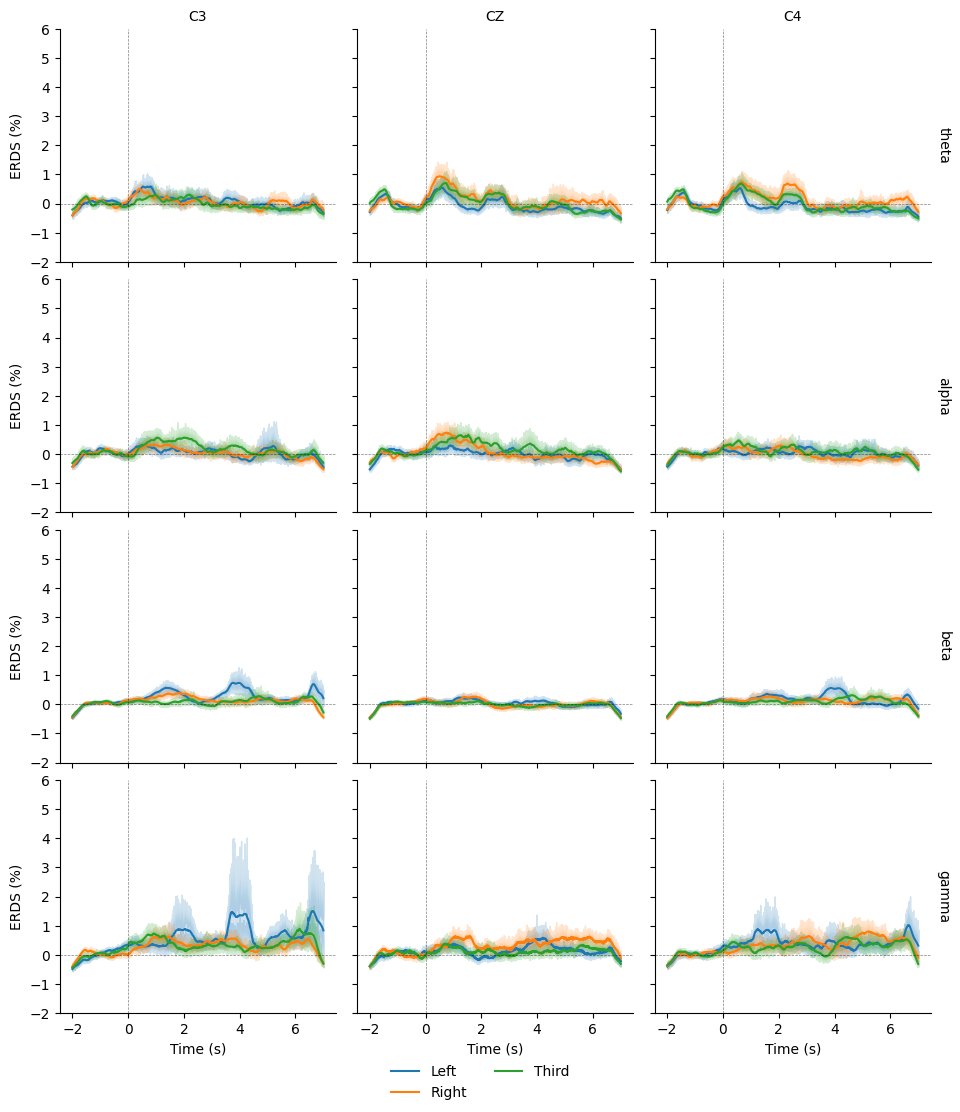

In [23]:
plot_ERDS(EEG_dict_corrected,EVENTS_dict)